## **1. Data Preparation**

In [1]:
# Step 1: Load Dataset
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

file_path = "C:/Users/User/UKM - Nur Azlin Binti Rusnan/Sem 3/Capstone Project/Dataset/2. Predictive Modeling Dataset/PM 7-1/PM-8.xlsx"
xls = pd.ExcelFile(file_path)

# Load the data from the first sheet
df = pd.read_excel(xls, sheet_name='Sheet1')

In [2]:
# Step 2: Preprocess the Sentiment Data for BERT
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["USS Comment"], df["Sentiment"], test_size=0.2, stratify=df["Sentiment"]
)

# Check distribution
print(train_texts.head(), train_labels.head())

# Define label mapping
label_mapping = {"Negative": 0, "Positive": 1}
train_labels = train_labels.map(label_mapping)
val_labels = val_labels.map(label_mapping)


# Check data distributions and sample sizes
train_texts.head(), train_labels.head(), len(train_texts), len(val_texts)

9185     thank you providing work around singleton malc...
10700                                                   ok
2801                               very good quick support
5705                 thank you prompt response appreciated
3721                   great service from sadia happy face
Name: USS Comment, dtype: object 9185     Positive
10700    Positive
2801     Positive
5705     Positive
3721     Positive
Name: Sentiment, dtype: object


(9185     thank you providing work around singleton malc...
 10700                                                   ok
 2801                               very good quick support
 5705                 thank you prompt response appreciated
 3721                   great service from sadia happy face
 Name: USS Comment, dtype: object,
 9185     1
 10700    1
 2801     1
 5705     1
 3721     1
 Name: Sentiment, dtype: int64,
 11283,
 2821)

### **a. Feature Engineering**

Use technique like BERT to convert comments into numerical representations.

In [9]:
# Step 3: Fine-Tune to my dataset, so BERT can learn the "lenggok" of user's comment.

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = BertForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", num_labels=2, ignore_mismatched_sizes=True)

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encodings.items()}

# Encode the data
def encode_data(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    encodings['labels'] = torch.tensor(list(labels))
    return encodings

train_encodings = encode_data(train_texts, train_labels, tokenizer)
val_encodings = encode_data(val_texts, val_labels, tokenizer)

train_dataset = CustomDataset(train_encodings)
val_dataset = CustomDataset(val_encodings)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=True,
)

# Trainer with metrics
def compute_metrics(pred):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Define the predict_sentiment function
def predict_sentiment(texts, model, tokenizer, batch_size=32):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(list(batch_texts), return_tensors="pt", truncation=True, padding=True, max_length=128)
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, axis=1).tolist()
            predictions.extend(preds)
    return predictions

# Train the model
trainer.train()

from sklearn.metrics import classification_report
predictions = predict_sentiment(val_texts, model, tokenizer)
print(classification_report(val_labels, predictions))

# Save the trained model
model.save_pretrained("bert_sentiment_model_v3")
tokenizer.save_pretrained("bert_sentiment_model_v3")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.126500,0.081671,0.971287,0.983751,0.993517,0.974176
2,0.086200,0.083676,0.974477,0.985646,0.989196,0.982122


              precision    recall  f1-score   support

           0       0.86      0.91      0.88       304
           1       0.99      0.98      0.99      2517

    accuracy                           0.97      2821
   macro avg       0.92      0.95      0.94      2821
weighted avg       0.98      0.97      0.97      2821



('bert_sentiment_model_v3\\tokenizer_config.json',
 'bert_sentiment_model_v3\\special_tokens_map.json',
 'bert_sentiment_model_v3\\vocab.txt',
 'bert_sentiment_model_v3\\added_tokens.json')

In [10]:
# Step 4: Generate Predictions Using the Fine-Tuned BERT Model

from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the fine-tuned BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert_sentiment_model_v3")
model = BertForSequenceClassification.from_pretrained("bert_sentiment_model_v3")

# Predict sentiments for `USS Comment`
df['Predicted_Sentiment'] = predict_sentiment(df['USS Comment'].fillna(''), model, tokenizer)
df.head()

,Number,City,Country,Region,Average Response (calculated),USS Comment,String value,Sentiment,Updated,Year,Month-Year,Language,SA_Predicted Sentiment,Confidence,Predicted_Sentiment
0,INC19299231,Midrand,South Africa,EAME,1,speedy and excellent followup and communicatio...,Very Satisfied,Positive,2024-11-01 08:40:00,2024,November,english,Positive,0.928918,1
1,INC19296281,Guyancourt,France,EAME,1,problem fixed quickly. thank you,Very Satisfied,Positive,2024-11-01 10:32:00,2024,November,english,Positive,0.938008,1
2,INC19300529,Didsbury,United Kingdom,EAME,1,malcolm did a great job in problem solving and...,Very Satisfied,Positive,2024-11-01 14:10:00,2024,November,english,Positive,0.930640,1
3,INC19300258,Bracknell,United Kingdom,EAME,1,thanks for the swift and awesome support and f...,Very Satisfied,Positive,2024-11-01 15:03:00,2024,November,english,Positive,0.935296,1
4,INC19301011,Didsbury,United Kingdom,EAME,1,great support from malcolm as usual,Very Satisfied,Positive,2024-11-01 16:40:00,2024,November,english,Positive,0.929943,1


In [11]:
df.to_csv("updated_dataset_with_predictions.csv", index=False)

In [1]:
# Load the save file to save time
import pandas as pd


file_path = "C:/Users/User/UKM - Nur Azlin Binti Rusnan/Sem 3/Capstone Project/updated_dataset_with_predictions_new.csv"  
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())

        Number        City         Country Region  \
0  INC19299231     Midrand    South Africa   EAME   
1  INC19296281  Guyancourt          France   EAME   
2  INC19300529    Didsbury  United Kingdom   EAME   
3  INC19300258   Bracknell  United Kingdom   EAME   
4  INC19301011    Didsbury  United Kingdom   EAME   

   Average Response (calculated)  \
0                              1   
1                              1   
2                              1   
3                              1   
4                              1   

                                         USS Comment    String value  \
0  speedy and excellent followup and communicatio...  Very Satisfied   
1                   problem fixed quickly. thank you  Very Satisfied   
2  malcolm did a great job in problem solving and...  Very Satisfied   
3  thanks for the swift and awesome support and f...  Very Satisfied   
4                great support from malcolm as usual  Very Satisfied   

  Sentiment          Updated  Y

## **Exploratory Data Analysis (EDA)**

To higlight key patterns, class imbalance and relationships

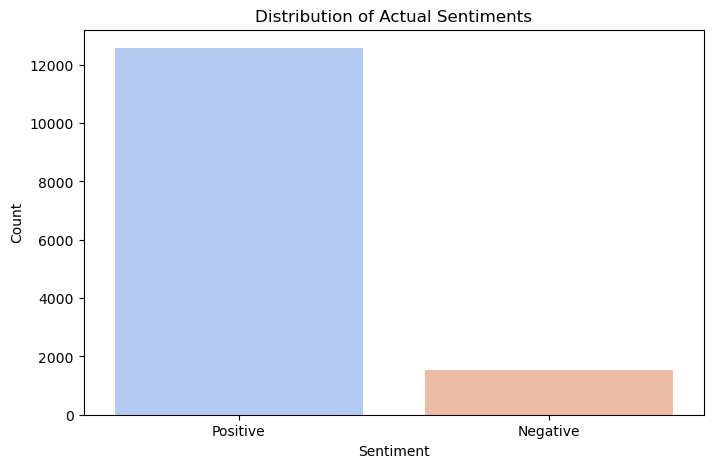

In [2]:
# Distribution of sentiments (actual and predicted)

import matplotlib.pyplot as plt
import seaborn as sns


# 1. Distribution of actual sentiments
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Sentiment', palette='coolwarm', order=df['Sentiment'].value_counts().index)
plt.title('Distribution of Actual Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

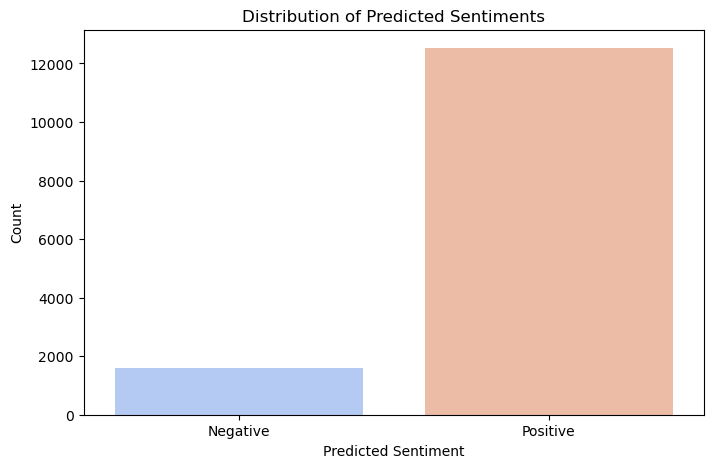

In [3]:
# 2. Distribution of predicted sentiments
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Predicted_Sentiment', palette='coolwarm')
plt.title('Distribution of Predicted Sentiments')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

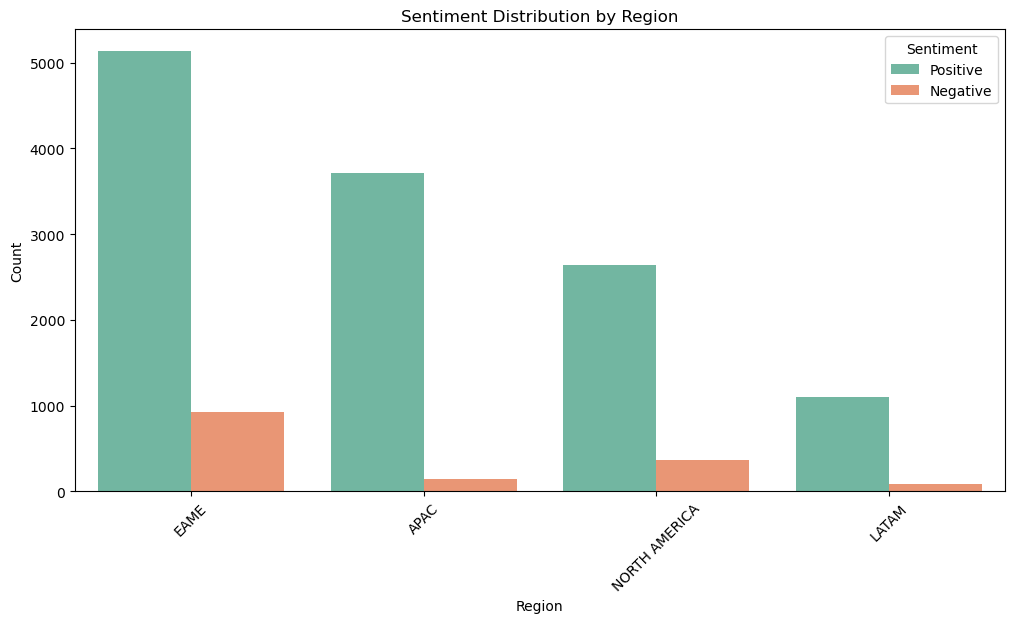

In [5]:
# 3. Sentiment distribution by Region
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Region', hue='Sentiment', palette='Set2', order=df['Region'].value_counts().index)
plt.title('Sentiment Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [4]:
# Feature Engineering for Predictive Modeling

# Perform One-Hot Encoding for both Country and Region
df = df.loc[:, ~df.columns.str.startswith("Region_")]  
df = df.loc[:, ~df.columns.str.startswith("Country_")]  

# Apply one-hot encoding
region_encoded = pd.get_dummies(df['Region'], prefix='Region', dtype=int)
country_encoded = pd.get_dummies(df['Country'], prefix='Country', dtype=int)

# Concatenate the new encoded features with the original dataframe
df = pd.concat([df, region_encoded, country_encoded], axis=1)

# Remove duplicate columns if any
df = df.loc[:, ~df.columns.duplicated()]

# Prepare feature set and target (without Country_Freq)
X = df[list(region_encoded.columns) + list(country_encoded.columns) + ['Predicted_Sentiment']]
y = df['Sentiment'].map({"Positive": 1, "Negative": 0})  # Binary target mapping


# Verify output
print("Features (X):", X.head())
print("Target (y):", y.head())

Features (X):    Region_APAC  Region_EAME  Region_LATAM  Region_NORTH AMERICA  \
0            0            1             0                     0   
1            0            1             0                     0   
2            0            1             0                     0   
3            0            1             0                     0   
4            0            1             0                     0   

   Country_Argentina  Country_Australia  Country_Austria  Country_Belarus  \
0                  0                  0                0                0   
1                  0                  0                0                0   
2                  0                  0                0                0   
3                  0                  0                0                0   
4                  0                  0                0                0   

   Country_Belgium  Country_Brazil  ...  Country_Spain  Country_Sweden  \
0                0               0  ...       

### **Data Splitting**

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Model Comparison and Selection**

In [7]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

# Perform One-Hot Encoding for both Country and Region
df = df.loc[:, ~df.columns.str.startswith("Region_")]  
df = df.loc[:, ~df.columns.str.startswith("Country_")]  

# Apply one-hot encoding
region_encoded = pd.get_dummies(df['Region'], prefix='Region', dtype=int)
country_encoded = pd.get_dummies(df['Country'], prefix='Country', dtype=int)

# Concatenate the new encoded features with the original dataframe
df = pd.concat([df, region_encoded, country_encoded], axis=1)

# Remove duplicate columns if any
df = df.loc[:, ~df.columns.duplicated()]

# Prepare feature set and target (without Country_Freq)
X = df[list(region_encoded.columns) + list(country_encoded.columns) + ['Predicted_Sentiment']]
y = df['Sentiment'].map({"Positive": 1, "Negative": 0})  # Binary target mapping

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models (Adding Logistic Regression)
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),  # Enable probability for ROC-AUC
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000)  # Ensure convergence
}

# Train, Predict, and Evaluate
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    
    model.fit(X_train, y_train)
    
    # Predict on original test set
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Evaluate
    accuracy = (predictions == y_test).mean()
    roc_auc = roc_auc_score(y_test, probabilities) if probabilities is not None else "N/A"
    classification_rep = classification_report(y_test, predictions, digits=4)
    confusion_mat = confusion_matrix(y_test, predictions)
    
    # Store results
    results[name] = {
        "Accuracy": round(accuracy, 4),
        "ROC-AUC": round(roc_auc, 4) if roc_auc != "N/A" else "N/A",
        "Classification Report": classification_rep,
        "Confusion Matrix": confusion_mat
    }

# Display Results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"ROC-AUC: {metrics['ROC-AUC']}")
    print("Classification Report:")
    print(metrics["Classification Report"])
    print("Confusion Matrix:")
    print(metrics["Confusion Matrix"])
    print("\n" + "-"*50 + "\n")


Training Random Forest...
Training SVM...
Training Gradient Boosting...
Training Logistic Regression...
Model: Random Forest
Accuracy: 0.9762
ROC-AUC: 0.9463
Classification Report:
              precision    recall  f1-score   support

           0     0.8921    0.8949    0.8935       314
           1     0.9868    0.9864    0.9866      2507

    accuracy                         0.9762      2821
   macro avg     0.9394    0.9407    0.9401      2821
weighted avg     0.9763    0.9762    0.9763      2821

Confusion Matrix:
[[ 281   33]
 [  34 2473]]

--------------------------------------------------

Model: SVM
Accuracy: 0.9762
ROC-AUC: 0.9345
Classification Report:
              precision    recall  f1-score   support

           0     0.8921    0.8949    0.8935       314
           1     0.9868    0.9864    0.9866      2507

    accuracy                         0.9762      2821
   macro avg     0.9394    0.9407    0.9401      2821
weighted avg     0.9763    0.9762    0.9763      2821



**Insights:**

All models are showing similar results. It is likely that the Predicted_Sentiment (from BERT embeddings) are highly predictive and the classification task is not complex enough to differentiate between models.

In [8]:
# hyperparameter tuning

# Import necessary libraries for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grids for each model
param_grids = {
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    "SVM": {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1]
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.7, 0.8, 1.0]
    },
    "Logistic Regression": {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
}

# Perform hyperparameter tuning using RandomizedSearchCV
tuned_models = {}
for name, model in models.items():
    if name in param_grids:
        random_search = RandomizedSearchCV(model, param_grids[name], n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
        random_search.fit(X_train, y_train)
        tuned_models[name] = random_search.best_estimator_

# Train, Predict, and Evaluate using the best-tuned models
results_tuned = {}
for name, model in tuned_models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Predict on test set
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Evaluate
    accuracy = (predictions == y_test).mean()
    roc_auc = roc_auc_score(y_test, probabilities) if probabilities is not None else "N/A"
    classification_rep = classification_report(y_test, predictions, digits=4)
    confusion_mat = confusion_matrix(y_test, predictions)
    
    # Store results
    results_tuned[name] = {
        "Accuracy": round(accuracy, 4),
        "ROC-AUC": round(roc_auc, 4) if roc_auc != "N/A" else "N/A",
        "Classification Report": classification_rep,
        "Confusion Matrix": confusion_mat
    }

# Convert results to a DataFrame and display
df_results_tuned = pd.DataFrame.from_dict(results_tuned, orient='index')
df_results_tuned


,Accuracy,ROC-AUC,Classification Report,Confusion Matrix
Random Forest,0.9762,0.9454,precision recall f1-score ...,"[[281, 33], [34, 2473]]"
SVM,0.9762,0.9530,precision recall f1-score ...,"[[281, 33], [34, 2473]]"
Gradient Boosting,0.9762,0.9462,precision recall f1-score ...,"[[281, 33], [34, 2473]]"
Logistic Regression,0.9762,0.9407,precision recall f1-score ...,"[[281, 33], [34, 2473]]"


### **Geographical Insights into Predicted CSAT Scores**

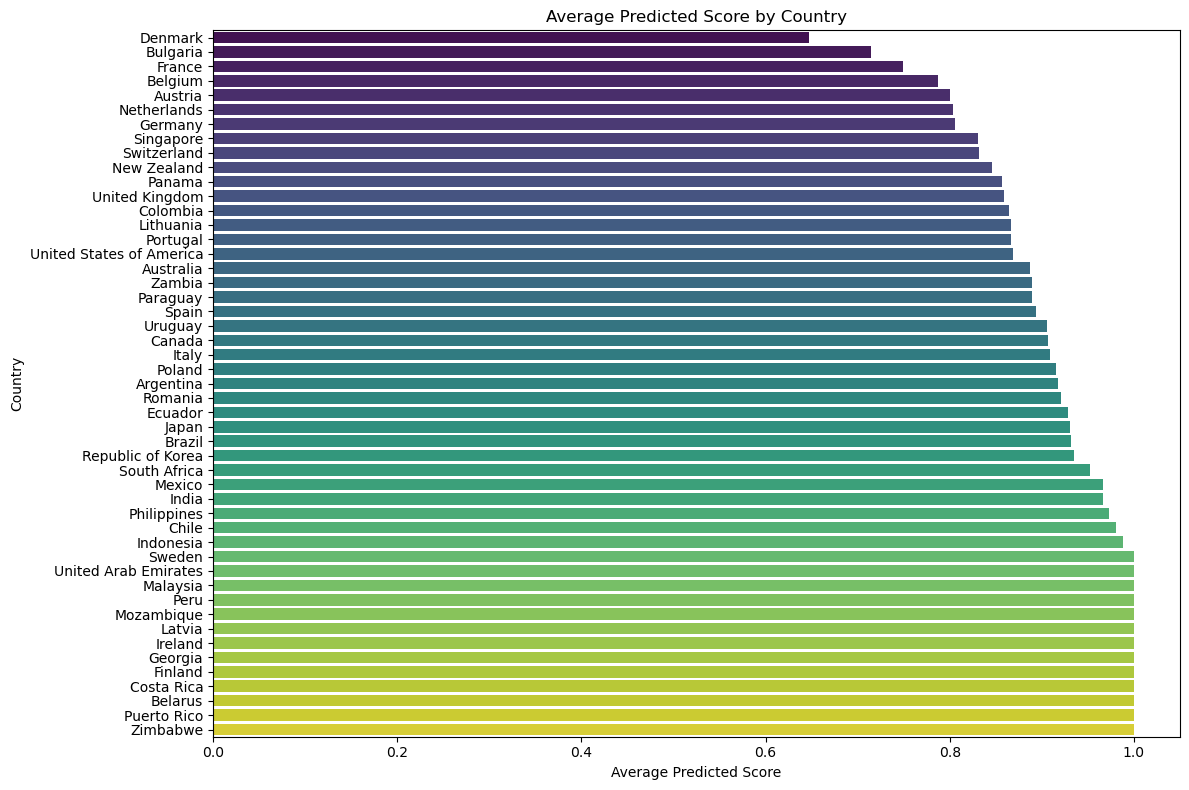

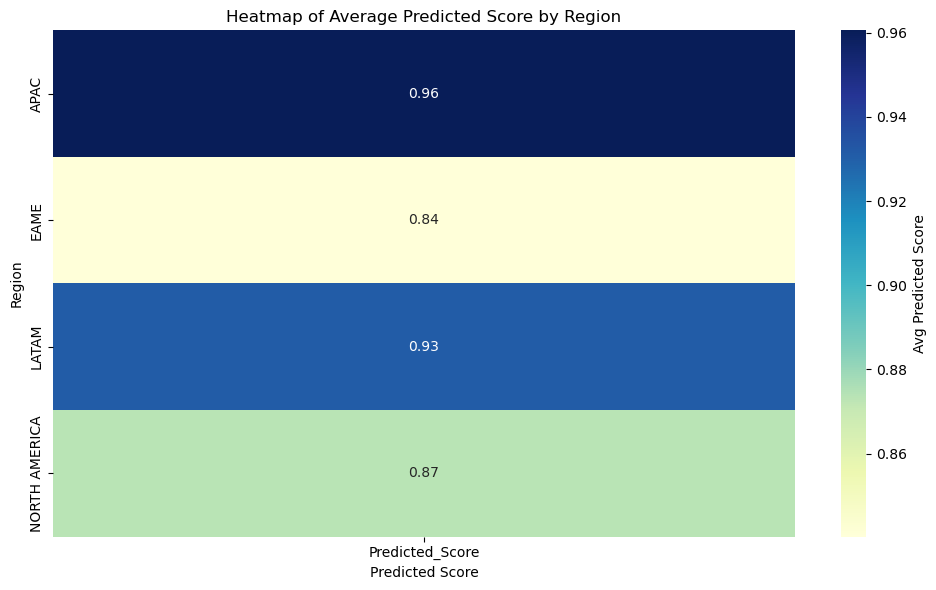

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict CSAT Score Using Random Forest

df['Predicted_Score'] = rf_model.predict(X)  

# Step 2: Bar Chart for Average Predicted Score by Country
# Calculate average predicted scores for each country
country_avg_pred = df.groupby('Country')['Predicted_Score'].mean().sort_values()

# Plot the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=country_avg_pred.values, y=country_avg_pred.index, palette="viridis")
plt.title("Average Predicted Score by Country")
plt.xlabel("Average Predicted Score")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# Step 3: Heatmap for Average Predicted Score by Region
# Pivot the data to create a heatmap-friendly format
region_avg_pred = df.pivot_table(index='Region', values='Predicted_Score', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(region_avg_pred, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Avg Predicted Score'})
plt.title("Heatmap of Average Predicted Score by Region")
plt.xlabel("Predicted Score")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

## **Model Testing on Unseen Data**

In [11]:
from joblib import dump, load
import torch


# Use Random Forest as the final model
rf_model = rf_model

# Save the trained model
dump(rf_model, "rf_model.pkl")
print("Random Forest model saved as 'random_forest_model.pkl'.")


from transformers import BertTokenizer, BertForSequenceClassification

# Load the fine-tuned BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert_sentiment_model_v3")
sentiment_model = BertForSequenceClassification.from_pretrained("bert_sentiment_model_v3")

# Function to make predictions for new inputs
def predict_csat_summary(location_type, location_value, df, comment=None, sentiment_model=None, tokenizer=None, rf_model=None, region_encoded=None):
    try:
        summary = {}
        
        # Step 1: Predict sentiment for the comment, if provided
        if comment and sentiment_model and tokenizer and rf_model and region_encoded is not None:
            inputs = tokenizer(comment, return_tensors="pt", truncation=True, padding=True, max_length=128)
            outputs = sentiment_model(**inputs)
            sentiment_score_idx = torch.argmax(outputs.logits).item()  # Get the predicted sentiment class index
            sentiment_encoded = 1 if sentiment_score_idx == 1 else 0  # Use numeric encoding (1 for Positive, 0 for Negative)
            
            # Frequency encoding for country
            country_freq = df['Country'].value_counts(normalize=True).to_dict()
            country_contribution = country_freq.get(location_value, 0)  # Default to 0 if country is not in the dataset

            # One-hot encoding for region
            region_columns = list(region_encoded.columns)
            region_values = [1 if f"Region_{location_value}" == col else 0 for col in region_columns]

            # Combine features
            input_features = [country_contribution] + region_values + [sentiment_encoded]

            # Predict CSAT score using Random Forest model
            predicted_csat_score = rf_model.predict([input_features])[0]
            
            # Add comment CSAT summary
            summary['Comment CSAT Summary'] = {
                "Comment": comment,
                "Predicted Sentiment": sentiment_encoded,
            }
        
        # Step 2: Filter data based on location type (Region or Country)
        if location_type.lower() == "region":
            filtered_data = df[df['Region'] == location_value]
        elif location_type.lower() == "country":
            filtered_data = df[df['Country'] == location_value]
        else:
            return {"Error": "Invalid location type. Use 'Region' or 'Country'."}
        
        if filtered_data.empty:
            return {"Error": f"No data available for {location_type}: {location_value}"}
        
        # Step 3: Calculate metrics
        avg_csat = round(filtered_data['Predicted_Score'].mean(), 2)
        total_responses = len(filtered_data)
        
        # Define feedback categories using numeric values (1 for Positive, 0 for Negative)
        positive_responses = filtered_data[filtered_data['Predicted_Sentiment'] == 1].shape[0]
        negative_responses = filtered_data[filtered_data['Predicted_Sentiment'] == 0].shape[0]
        
        # Calculate percentages
        positive_percentage = (positive_responses / total_responses) * 100 if total_responses > 0 else 0
        negative_percentage = (negative_responses / total_responses) * 100 if total_responses > 0 else 0
        
        # Add location-specific summary
        summary[f"{location_type.capitalize()} CSAT Summary"] = {
            location_type.capitalize(): location_value,
            "Average Predicted CSAT": avg_csat,
            "Positive Feedback (%)": positive_percentage,
            "Negative Feedback (%)": negative_percentage,
            "Number of Responses": total_responses
        }
        
        return summary
    except Exception as e:
        return {"Error": str(e)}
    
# Example usage
example_comment = "The service was amazing and resolved my issue quickly!"
example_region = "APAC"
example_country = "Bulgaria"

# Prediction
summary = {}
summary.update(predict_csat_summary(
    "region", example_region, df, comment=example_comment, 
    sentiment_model=sentiment_model, tokenizer=tokenizer, 
    rf_model=rf_model, region_encoded=region_encoded
))
summary.update(predict_csat_summary("country", example_country, df))

# Display results
for section, metrics in summary.items():
    print(f"\n{section}:")
    if isinstance(metrics, dict):
        for key, value in metrics.items():
            print(f"{key:<60} {value:<30}")
    else:
        print(metrics)


Random Forest model saved as 'random_forest_model.pkl'.

Comment CSAT Summary:
Comment                                                      The service was amazing and resolved my issue quickly!
Predicted Sentiment                                          1                             

Region CSAT Summary:
Region                                                       APAC                          
Average Predicted CSAT                                       0.96                          
Positive Feedback (%)                                        96.05911330049261             
Negative Feedback (%)                                        3.9408866995073892            
Number of Responses                                          3857                          

Country CSAT Summary:
Country                                                      Bulgaria                      
Average Predicted CSAT                                       0.71                          
Positive Feedback (%)   

C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [32]:
!pip install imbalanced-learn

In [4]:
!pip install transformers